# lab assignment 2
Big Data Analytics - Kelly Hwang

### resources
- https://www.usatoday.com/story/money/economy/2018/11/12/us-economy-grows-cities-adding-most-jobs/38319445/


- https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime
- https://hackernoon.com/reshaping-data-in-python-fa27dda2ff77
- https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null
- https://stackoverflow.com/questions/23836277/add-leading-zeros-to-strings-in-pandas-dataframe
- https://stackoverflow.com/questions/42820696/using-prophet-package-to-predict-by-group-in-dataframe-in-r

In [650]:
import pandas as pd
import numpy as np
import timeit
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import io
import datetime
import seaborn as sns
import warnings
import heapq
import matplotlib

In [ ]:
# install with conda install -c conda-forge fbprophet
from fbprophet import Prophet

In [ ]:
# remove truncate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 1000
np.set_printoptions(threshold=np.nan)

### lab objectives
Can we predict which three zip codes provide the best investment opportunity for the Syracuse Real Estate Investment Trust (SREIT)?

Develop time series plots for the following Arkansas metro areas:
- Hot Springs, Little Rock, Fayetteville, Searcy
- Present all values from 1997 to present
- Average at the metro area level

Using data from Zillow:
- Develop model(s) for forecasting average median housing value by zip code for 2018
- Use the historical data from 1997 through 2017 as your training data
- Integrate data from other sources (think Bureau of Labor Statistics and Census data) to improve upon your base model(s)

Answer the following questions:
- What technique/algorithm/decision process did you use to down sample? (BONUS FOR NOT DOWN SAMPLING)
- What three zip codes provide the best investment opportunity for the SREIT?
- Why?

### data munging & preparation
Upon initial examination of the base csv zip code data:
- data contains avg value of single family homes per zip code/metro area
- some metro areas are blank, but every row contains a zip code, city, state, and countyname.
- all column names are dates, which will need to be transposed into rows
- some zip codes contain no data for certain dates
- all zip codes will need to be transposed to columns for forecasting model

In [471]:
## archived / dropped code

# drop variable column
# newdf.drop(['variable'], axis = 1, inplace = True)

# preview zip codes missing leading 0
#newdf[newdf['RegionName'].str.len() == 4].head()

# preview zipcode fix
#newdf[(newdf['City'] == 'Danbury') & (newdf['State'] == 'CT')].head()

# obtain & scrub

In [608]:
# read in zip code csv
df = pd.read_csv('zip_data.csv')
df.head()

,Top Job Growth,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
0,NaN,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,334200.0,335400.0,...,1038600,1041400,1042100,1041900,1043600,1047000,1048600,1046800,1046500,1051600
1,NaN,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,...,332600,334500,335900,337100,338400,338400,336900,336000,335900,335100
2,NaN,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,498100.0,500900.0,...,1321000,1324800,1322600,1319900,1319400,1318400,1317200,1318000,1320700,1327000
3,NaN,93144,79936,El Paso,TX,El Paso,El Paso County,4,77300.0,77300.0,...,121300,122200,123000,123600,124500,125700,126300,126800,127500,128200
4,NaN,91940,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,5,95400.0,95600.0,...,176400,176800,176900,177400,178000,178600,179400,180200,180900,181700


In [609]:
# add leading 0 to 4 digit zip codes
df['RegionName'] = df['RegionName'].apply(lambda x: '{0:0>5}'.format(x))

In [610]:
# drop columns
df.drop(['RegionID'], axis = 1, inplace = True)
df.drop(['SizeRank'], axis = 1, inplace = True)
df.drop(['CountyName'], axis = 1, inplace = True)

In [611]:
# rename columns
df = df.rename(index = str, columns = {"Top Job Growth": "topjobgrowth", "RegionName": "zip", "City": "city", "State": "state",
                                            "Metro": "metro"})

In [657]:
df.head()

,topjobgrowth,zip,city,state,metro,1996-04,1996-05,1996-06,1996-07,1996-08,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
0,NaN,60657,Chicago,IL,Chicago-Naperville-Elgin,334200.0,335400.0,336500.0,337600.0,338500.0,...,1038600,1041400,1042100,1041900,1043600,1047000,1048600,1046800,1046500,1051600
1,NaN,77494,Katy,TX,Houston-The Woodlands-Sugar Land,210400.0,212200.0,212200.0,210700.0,208300.0,...,332600,334500,335900,337100,338400,338400,336900,336000,335900,335100
2,NaN,60614,Chicago,IL,Chicago-Naperville-Elgin,498100.0,500900.0,503100.0,504600.0,505500.0,...,1321000,1324800,1322600,1319900,1319400,1318400,1317200,1318000,1320700,1327000
3,NaN,79936,El Paso,TX,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,121300,122200,123000,123600,124500,125700,126300,126800,127500,128200
4,NaN,77449,Katy,TX,Houston-The Woodlands-Sugar Land,95400.0,95600.0,95800.0,96100.0,96400.0,...,176400,176800,176900,177400,178000,178600,179400,180200,180900,181700


In [614]:
# copy to new df for future reference
df_base = df

In [669]:
# how many metro areas are there per state? - ordered by most metro areas to least
df.groupby('state')['metro'].nunique().sort_values(ascending = False).head(15)

state
TX    56
OH    41
IN    39
NC    38
GA    34
PA    33
CA    31
MI    29
FL    28
IL    27
TN    27
NY    26
WI    25
MO    25
MN    23
Name: metro, dtype: int64

In [656]:
# create datenames column variables
datenames = df.columns[5:281]
print(datenames)

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='object', length=274)


In [659]:
## clean df dataframe for exploration

# melt df to long format
df_melt = pd.melt(df, id_vars = ['zip', 'city', 'state', 'metro'], value_vars = datenames)

# rename columns
df_melt = df_melt.rename(index = str, columns = {"variable": "date"})

# drop na values
df_melt.dropna(inplace = True)

# change date to date format
df_melt['date'] = pd.to_datetime(df_melt['date'], format = '%Y-%m')

# extract month column
df_melt['month'] = df_melt['date'].dt.month

# convert month number format
df_melt['month'] = df_melt.month.map("{:02}".format).astype('str')

# extract years column
df_melt['year'] = df_melt['date'].dt.year.astype('str')

# remove 1996 data
# df_melt = df_melt[df_melt['year'] != '1996']

In [666]:
# top 10 highest average home values by state in 2018
df_melt[df_melt['year']=='2018'].groupby('state')['value'].mean().sort_values(ascending = False).head(10)

state
DC    811585.648148
CA    757504.701577
HI    697839.919355
MA    463019.224620
CO    434521.063830
WA    411164.059305
NJ    402386.503984
NY    394115.227878
UT    341825.917431
MD    336392.650273
Name: value, dtype: float64

In [670]:
# top 10 highest average home values by metro area in 2018
df_melt[df_melt['year']=='2018'].groupby('metro')['value'].mean().sort_values(ascending = False).head(30)

metro
San Jose-Sunnyvale-Santa Clara               1.637981e+06
San Francisco-Oakland-Hayward                1.328119e+06
Glenwood Springs                             1.240951e+06
Summit Park                                  1.023750e+06
Los Angeles-Long Beach-Anaheim               9.309977e+05
Santa Maria-Santa Barbara                    9.271787e+05
Vineyard Haven                               9.043867e+05
Urban Honolulu                               8.874222e+05
Edwards                                      8.765833e+05
Napa                                         8.424917e+05
Santa Cruz-Watsonville                       8.024521e+05
San Diego-Carlsbad                           7.727231e+05
Salinas                                      7.323408e+05
Kahului-Wailuku-Lahaina                      7.264296e+05
Santa Rosa                                   7.262200e+05
Gardnerville Ranchos                         6.718562e+05
Brunswick                                    6.599300e+05
Oxnard-T

In [309]:
# new df for arkansas only metro areas Hot Springs, Little Rock, Fayetteville, Searcy
akdf = df[(df['metro']=='Hot Springs') | (df['metro']=='Little Rock') | (df['metro']=='Fayetteville-Springdale-Rogers') 
          | (df['metro']=='Searcy')]

# new df for top job growth metros only
topdf = df[df['topjobgrowth']=='Y']

# exploring arkansas metro areas

In [672]:
akdf.head()

,topjobgrowth,zip,city,state,metro,1996-04,1996-05,1996-06,1996-07,1996-08,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
296,NaN,71913,Hot Springs,AR,Hot Springs,82100.0,81900.0,81600.0,81300.0,81000.0,...,145100,144800,145400,146500,147000,147000,147100,147800,149200,150500
798,Y,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,83100.0,83500.0,83700.0,83800.0,83700.0,...,215100,216300,217500,218400,219400,221400,223500,225400,227300,228400
847,Y,72764,Springdale,AR,Fayetteville-Springdale-Rogers,NaN,NaN,NaN,NaN,NaN,...,151600,153000,154200,154800,155400,156500,157800,158900,160000,160900
1520,Y,72756,Rogers,AR,Fayetteville-Springdale-Rogers,75600.0,75800.0,76100.0,76500.0,77000.0,...,154600,155600,156500,157600,158800,160300,162100,163700,164700,165100
1564,Y,72758,Rogers,AR,Fayetteville-Springdale-Rogers,103600.0,103500.0,103200.0,102600.0,101800.0,...,213800,214600,214700,214700,215100,216800,218900,220900,223000,225200


In [312]:
# create datenames column variables
datenames = df.columns[5:281]
print(datenames)

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
       '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='object', length=274)


In [313]:
## clean arkansas dataframe for initial review

# melt df to long format
akdf_melt = pd.melt(akdf, id_vars = ['zip', 'city', 'state', 'metro'], value_vars = datenames)

# rename columns
akdf_melt = akdf_melt.rename(index = str, columns = {"variable": "date"})

# drop na values
akdf_melt.dropna(inplace = True)

# change date to date format
akdf_melt['date'] = pd.to_datetime(akdf_melt['date'], format = '%Y-%m')

# extract month column
akdf_melt['month'] = akdf_melt['date'].dt.month

# convert month number format
akdf_melt['month'] = akdf_melt.month.map("{:02}".format).astype('str')

# extract years column
akdf_melt['year'] = akdf_melt['date'].dt.year.astype('str')

# remove 1996 data
akdf_melt = akdf_melt[akdf_melt['year'] != '1996']

In [674]:
akdf_melt.head()

,zip,city,state,metro,date,value,month,year
306,71913,Hot Springs,AR,Hot Springs,1997-01-01,79200.0,01,1997
307,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,1997-01-01,83800.0,01,1997
309,72756,Rogers,AR,Fayetteville-Springdale-Rogers,1997-01-01,79900.0,01,1997
310,72758,Rogers,AR,Fayetteville-Springdale-Rogers,1997-01-01,101000.0,01,1997
311,72703,Fayetteville,AR,Fayetteville-Springdale-Rogers,1997-01-01,107100.0,01,1997


In [315]:
# avg value per AR metro area
akdf_melt.groupby('metro')['value'].mean().sort_values(ascending = False)

metro
Fayetteville-Springdale-Rogers    119597.957839
Hot Springs                       115423.962264
Searcy                             85482.553191
Name: value, dtype: float64

In [675]:
# median value per year for Fayetteville
akdf_melt[akdf_melt['metro']=='Fayetteville-Springdale-Rogers'].groupby('year')['value'].median()

year
1997     81050.0
1998     79050.0
1999     80750.0
2000     88050.0
2001     91800.0
2002     97250.0
2003    104000.0
2004    119000.0
2005    133500.0
2006    147050.0
2007    142900.0
2008    133700.0
2009    120500.0
2010    112150.0
2011    109050.0
2012    106500.0
2013    117550.0
2014    126000.0
2015    128750.0
2016    140000.0
2017    152850.0
2018    163600.0
2019    170500.0
Name: value, dtype: float64

In [317]:
# avg value per zip for Fayetteville sorted descending
akdf_melt[akdf_melt['metro']=='Fayetteville-Springdale-Rogers'].groupby('zip')['value'].mean().sort_values(ascending = False)

zip
72718    238120.000000
72703    165719.622642
72758    161903.773585
72712    160402.264151
72701    145347.547170
72704    140988.679245
72762    135095.094340
72715    131486.792453
72730    128334.716981
72714    127886.037736
72719    127339.245283
72764    127033.689840
72745    120537.358491
72732    111880.377358
72756    110693.584906
72761    105270.943396
72774    104627.547170
72751    104570.188679
72727     98629.056604
72734     95255.849057
64856     91919.245283
64831     82952.452830
72722     79410.566038
64843     71058.113208
Name: value, dtype: float64

In [318]:
# top 3 zip in Fayetteville info
df[(df.zip == '72718') | (df.zip == '72703') | (df.zip == '72758')]

,topjobgrowth,zip,city,state,metro,1996-04,1996-05,1996-06,1996-07,1996-08,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
1564,Y,72758,Rogers,AR,Fayetteville-Springdale-Rogers,103600.0,103500.0,103200.0,102600.0,101800.0,...,213800,214600,214700,214700,215100,216800,218900,220900,223000,225200
1575,Y,72703,Fayetteville,AR,Fayetteville-Springdale-Rogers,104900.0,105300.0,105600.0,105800.0,106000.0,...,227300,229000,230600,232000,233100,233600,234200,235800,237900,239400
12124,Y,72718,Cave Springs,AR,Fayetteville-Springdale-Rogers,NaN,NaN,NaN,NaN,NaN,...,255900,255700,254900,253800,253900,255100,256200,256900,259500,263300


**OBSERVATION: these 3 cities are also listed in top 25 job growth perspectives!**

In [319]:
akdf_melt.head()

,zip,city,state,metro,date,value,month,year
306,71913,Hot Springs,AR,Hot Springs,1997-01-01,79200.0,01,1997
307,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,1997-01-01,83800.0,01,1997
309,72756,Rogers,AR,Fayetteville-Springdale-Rogers,1997-01-01,79900.0,01,1997
310,72758,Rogers,AR,Fayetteville-Springdale-Rogers,1997-01-01,101000.0,01,1997
311,72703,Fayetteville,AR,Fayetteville-Springdale-Rogers,1997-01-01,107100.0,01,1997


In [320]:
# prepare for time series plot
plotting = akdf_melt[['metro', 'date', 'value']]

In [321]:
# clean for time series plot
# average value per metro area per month
plotting = plotting.pivot_table(index=['date', 'metro'], values='value', aggfunc='mean').reset_index()
plotting.set_index('date')
plotting.head()

,date,metro,value
0,1997-01-01,Fayetteville-Springdale-Rogers,79900.000000
1,1997-01-01,Hot Springs,72225.000000
2,1997-01-01,Searcy,62180.000000
3,1997-02-01,Fayetteville-Springdale-Rogers,80431.818182
4,1997-02-01,Hot Springs,72275.000000


In [652]:
# date formatter for graphs

def myFormatter(x, pos):
      return pd.to_datetime(x).strftime('%Y')

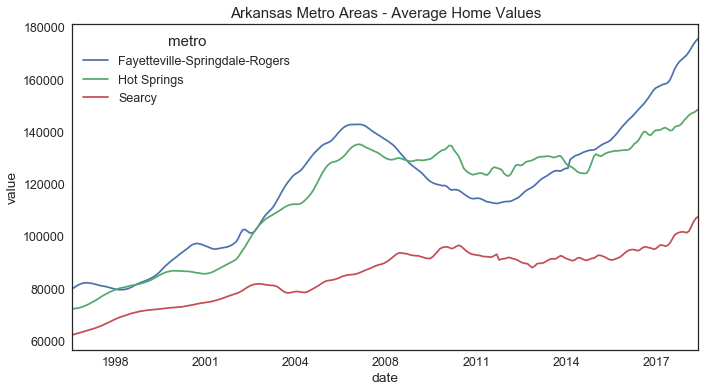

In [654]:
plt.figure(figsize=(10,6))

sns.set_style("white")

ax = sns.tsplot(plotting, time='date', unit='metro', condition='metro', value='value')
sns.set(font_scale=1.25)
ax.set_title('Arkansas Metro Areas - Average Home Values')
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))

# forecasting arkansas metro areas (mini test)

In [567]:
# prepare dataframe for prophet
forecasting = akdf_melt[['zip', 'date', 'value']]
forecasting = forecasting.set_index('zip')

In [568]:
forecasting = forecasting.pivot_table(index=['date'], columns='zip', values='value', aggfunc='mean', dropna = True)

In [569]:
forecasting.head()

zip,64831,64843,64856,71901,71913,71964,71968,72012,72081,72102,...,72732,72734,72745,72751,72756,72758,72761,72762,72764,72774
date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,64500.0,57200.0,67600.0,67000.0,79200.0,74700.0,68000.0,70700.0,49200.0,NaN,...,77200.0,63700.0,82300.0,80100.0,79900.0,101000.0,71400.0,86900.0,NaN,63100.0
1997-02-01,64000.0,56900.0,67100.0,67000.0,78900.0,75000.0,68200.0,70900.0,49400.0,NaN,...,77800.0,63900.0,82700.0,80300.0,80600.0,102400.0,72300.0,88100.0,NaN,63400.0
1997-03-01,63600.0,56600.0,66800.0,67000.0,78800.0,75300.0,68500.0,71200.0,49600.0,NaN,...,78200.0,64100.0,83000.0,80400.0,81200.0,104300.0,73400.0,89200.0,NaN,64000.0
1997-04-01,63100.0,56400.0,66500.0,67100.0,78900.0,75500.0,68800.0,71400.0,49900.0,NaN,...,78500.0,64300.0,83200.0,80400.0,81700.0,106600.0,74400.0,90400.0,NaN,64700.0
1997-05-01,62800.0,56200.0,66200.0,67200.0,79200.0,75800.0,69100.0,71700.0,50200.0,NaN,...,78700.0,64300.0,83400.0,80300.0,82100.0,109000.0,75200.0,91300.0,NaN,65400.0


In [570]:
dfs = []
for i, zip in enumerate(forecasting.columns):
    dfs.append(forecasting.loc[forecasting.loc[:,zip].first_valid_index():,zip])
    dfs[i] = dfs[i].to_frame()
    dfs[i].name = zip
    dfs[i]['ds'] = dfs[i].index
    dfs[i].rename(columns = {zip: 'y'}, inplace = True)
    
print('firt time series zip code:', dfs[9].name)

firt time series zip code: 72102


In [571]:
# build last 9 months from 2018 as training data
dfstrain = []
dfstest = []
for df in dfs:
    dfstrain.append(df[:-9])
    dfstest.append(df[-9:])
print(dfstrain[0].tail())
print(dfstest[0])

                  y         ds
date                          
2017-12-01  91500.0 2017-12-01
2018-01-01  91800.0 2018-01-01
2018-02-01  92500.0 2018-02-01
2018-03-01  93600.0 2018-03-01
2018-04-01  95000.0 2018-04-01
                   y         ds
date                           
2018-05-01   96500.0 2018-05-01
2018-06-01   97300.0 2018-06-01
2018-07-01   98200.0 2018-07-01
2018-08-01  100000.0 2018-08-01
2018-09-01  101900.0 2018-09-01
2018-10-01  103200.0 2018-10-01
2018-11-01  104400.0 2018-11-01
2018-12-01  106000.0 2018-12-01
2019-01-01  107000.0 2019-01-01


In [572]:
# start time
currentDT = datetime.datetime.now()
print("start time:", currentDT.strftime("%Y-%m-%d %H:%M:%S"))

warnings.filterwarnings('ignore')

preds_ark = []
for i, df in enumerate(dfstrain):
    model = Prophet(interval_width=0.95, weekly_seasonality = True,
                   daily_seasonality = True)
    model.fit(df)
    pred_dates = model.make_future_dataframe(periods=30, freq='MS')
    preds_ark.append(model.predict(pred_dates))
    print(i, end=" ")

# end time   
currentDT = datetime.datetime.now()
print("")
print("end time:", currentDT.strftime("%Y-%m-%d %H:%M:%S"))

start time: 2019-02-23 15:36:11
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 
end time: 2019-02-23 15:37:32


In [585]:
# predictions
print(preds_ark[0][256:265][['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
print(dfstest[0])

            ds          yhat    yhat_lower    yhat_upper
256 2018-05-01  90292.693615  88571.542822  92029.730702
257 2018-06-01  90419.157980  88666.652369  92086.747889
258 2018-07-01  90552.390414  88705.638732  92375.247760
259 2018-08-01  90589.861403  88766.106682  92563.518415
260 2018-09-01  90611.496578  88832.925703  92538.256248
261 2018-10-01  90720.714237  88657.297554  92606.969392
262 2018-11-01  90908.044904  88725.756867  92919.869174
263 2018-12-01  90811.108113  88426.600190  93200.423893
264 2019-01-01  90697.185687  88033.773295  93163.269162
                   y         ds
date                           
2018-05-01   96500.0 2018-05-01
2018-06-01   97300.0 2018-06-01
2018-07-01   98200.0 2018-07-01
2018-08-01  100000.0 2018-08-01
2018-09-01  101900.0 2018-09-01
2018-10-01  103200.0 2018-10-01
2018-11-01  104400.0 2018-11-01
2018-12-01  106000.0 2018-12-01
2019-01-01  107000.0 2019-01-01


In [586]:
# evaluating difference in y and yhat for one zipcode
pred_eval = dfstest[0].set_index('ds')
predstojoin = preds_ark[0][256:265][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predstojoin = predstojoin.set_index('ds')
pred_eval['yhat'] = predstojoin['yhat']
pred_eval['diff'] = pred_eval['yhat'] - pred_eval['y']
pred_eval

,y,yhat,diff
ds,,,
2018-05-01,96500.0,90292.693615,-6207.306385
2018-06-01,97300.0,90419.157980,-6880.842020
2018-07-01,98200.0,90552.390414,-7647.609586
2018-08-01,100000.0,90589.861403,-9410.138597
2018-09-01,101900.0,90611.496578,-11288.503422
2018-10-01,103200.0,90720.714237,-12479.285763
2018-11-01,104400.0,90908.044904,-13491.955096
2018-12-01,106000.0,90811.108113,-15188.891887
2019-01-01,107000.0,90697.185687,-16302.814313


In [587]:
growth = [(preds_ark[i].iloc[-1, -1] - dfstrain[i].iloc[-1,0], i) for i in range(len(dfstrain))]

In [591]:
# 3 largest growth zipcode locations
largest = heapq.nlargest(3, growth)
print(largest)
print('3 zip codes with largest growth:')
for x, y in largest:
    print(dfs[y].name)

[(33369.88746687904, 16), (27150.842805195105, 29), (24016.821693799284, 20)]
3 zip codes with largest growth:
72712
72758
72719


In [592]:
pred_eval = dfstest[29].set_index('ds')
predstojoin = preds_ark[29][256:265]
predstojoin = predstojoin.set_index('ds')
pred_eval['yhat'] = predstojoin['yhat']
pred_eval['diff'] = abs(pred_eval['yhat'] - pred_eval['y'])
print('prediction off by $', round(pred_eval['diff'].mean(), 2), 'on average for zipcode', dfs[29].name)

prediction off by $ 1528.77 on average for zipcode 72758


# forecasting top job growth opportunity zip codes
### building the model

In [593]:
topdf.head()

,topjobgrowth,zip,city,state,metro,1996-04,1996-05,1996-06,1996-07,1996-08,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
10,Y,37013,Nashville,TN,Nashville-Davidson--Murfreesboro--Franklin,112400.0,112700.0,113000.0,113400.0,113900.0,...,212000,213600,214700,216100,218300,221100,224100,226200,227700,228800
11,Y,78660,Pflugerville,TX,Austin-Round Rock,138900.0,138600.0,138400.0,138500.0,138700.0,...,243800,244200,244900,245800,246500,246800,247300,248500,249600,250100
17,Y,37211,Nashville,TN,Nashville-Davidson--Murfreesboro--Franklin,97900.0,98000.0,98200.0,98400.0,98700.0,...,264200,265200,266400,267700,268700,270300,272400,273900,275100,276400
26,Y,28269,Charlotte,NC,Charlotte-Concord-Gastonia,126100.0,126600.0,127100.0,127600.0,128000.0,...,198300,198700,199500,200700,202200,204100,206400,208300,210000,211800
27,Y,78613,Cedar Park,TX,Austin-Round Rock,169600.0,169000.0,168600.0,168500.0,168700.0,...,297400,297100,297100,297100,297200,297800,299300,301500,304400,306500


In [472]:
# how many metro areas are there per state, that are projected to have highest job growth in 2019?
print('top job growth metro areas count by state:')
topdf.groupby('state')['metro'].nunique().sort_values(ascending = False)

top job growth metro areas count by state:


state
OR    5
CO    4
FL    4
AZ    3
WA    2
ID    2
TX    2
NV    2
NC    2
UT    2
GA    2
MO    1
IN    1
LA    1
SC    1
TN    1
AR    1
Name: metro, dtype: int64

In [474]:
# how many zip codes are there per state?
print('top job growth metro areas count by zip:')
topdf.groupby('state')['zip'].nunique().sort_values(ascending = False)

top job growth metro areas count by zip:


state
CO    177
FL    172
GA    168
AZ    155
OR    116
NC    116
TN     87
NV     80
TX     75
ID     38
UT     30
WA     28
AR     21
SC     13
IN     11
LA      8
MO      3
Name: zip, dtype: int64

In [475]:
## clean topjobs dataframe for initial review

# melt df to long format
topdf_melt = pd.melt(topdf, id_vars = ['zip', 'city', 'state', 'metro'], value_vars = datenames)

# rename columns
topdf_melt = topdf_melt.rename(index = str, columns = {"variable": "date"})

# drop na values
topdf_melt.dropna(inplace = True)

# change date to date format
topdf_melt['date'] = pd.to_datetime(topdf_melt['date'], format = '%Y-%m')

# extract month column
topdf_melt['month'] = topdf_melt['date'].dt.month

# convert month number format
topdf_melt['month'] = topdf_melt.month.map("{:02}".format).astype('str')

# extract years column
topdf_melt['year'] = topdf_melt['date'].dt.year.astype('str')

# remove 1996 data
topdf_melt = topdf_melt[topdf_melt['year'] != '1996']

In [480]:
topdf_melt.shape

(335402, 8)

In [594]:
topdf_melt.head()

,zip,city,state,metro,date,value,month,year
11682,37013,Nashville,TN,Nashville-Davidson--Murfreesboro--Franklin,1997-01-01,116400.0,01,1997
11683,78660,Pflugerville,TX,Austin-Round Rock,1997-01-01,140200.0,01,1997
11684,37211,Nashville,TN,Nashville-Davidson--Murfreesboro--Franklin,1997-01-01,101100.0,01,1997
11685,28269,Charlotte,NC,Charlotte-Concord-Gastonia,1997-01-01,129900.0,01,1997
11686,78613,Cedar Park,TX,Austin-Round Rock,1997-01-01,172400.0,01,1997


In [595]:
# prepare dataframe for prophet
forecasting = topdf_melt[['zip', 'date', 'value']]
forecasting = forecasting.set_index('zip')

In [596]:
forecasting = forecasting.pivot_table(index=['date'], columns='zip', values='value', aggfunc='mean', dropna = True)

In [597]:
forecasting.head()

zip,27013,27054,27502,27504,27511,27513,27518,27519,27520,27523,...,98684,98685,98686,98801,98802,98815,98822,98826,98828,98847
date,,,,,,,,,,,,,,,,,,,,,
1997-01-01,69300.0,69000.0,184100.0,87600.0,138900.0,163400.0,232500.0,216000.0,101200.0,194300.0,...,136200.0,157600.0,158500.0,133800.0,137300.0,128600.0,113200.0,165200.0,125900.0,127600.0
1997-02-01,70100.0,69800.0,185000.0,88200.0,138500.0,164200.0,233000.0,218000.0,102000.0,193900.0,...,137000.0,158300.0,159100.0,134100.0,137300.0,129100.0,113700.0,166100.0,126200.0,128300.0
1997-03-01,70900.0,70400.0,185900.0,88700.0,138400.0,165000.0,233200.0,219800.0,102600.0,193600.0,...,137700.0,158600.0,159400.0,134100.0,136900.0,129500.0,114100.0,166800.0,126300.0,128900.0
1997-04-01,71700.0,71100.0,186400.0,89300.0,138600.0,165800.0,233300.0,221500.0,103100.0,193200.0,...,138100.0,158800.0,159500.0,134100.0,136500.0,129800.0,114300.0,167400.0,126500.0,129400.0
1997-05-01,72300.0,71700.0,186500.0,89900.0,139100.0,166500.0,233500.0,222800.0,103700.0,192800.0,...,138400.0,158900.0,159300.0,133900.0,136000.0,130100.0,114400.0,167900.0,126500.0,129700.0


In [601]:
dfs = []
for i, zip in enumerate(forecasting.columns):
    dfs.append(forecasting.loc[forecasting.loc[:,zip].first_valid_index():,zip])
    dfs[i] = dfs[i].to_frame()
    dfs[i].name = zip
    dfs[i]['ds'] = dfs[i].index
    dfs[i].rename(columns = {zip: 'y'}, inplace = True)
    
print('firt time series zip code:', dfs[0].name)

firt time series zip code: 27013


In [602]:
# build last 9 months from 2018 as training data
dfstrain = []
dfstest = []
for df in dfs:
    dfstrain.append(df[:-9])
    dfstest.append(df[-9:])
print(dfstrain[0].tail())
print(dfstest[0])

                   y         ds
date                           
2017-12-01  144900.0 2017-12-01
2018-01-01  144800.0 2018-01-01
2018-02-01  145800.0 2018-02-01
2018-03-01  148500.0 2018-03-01
2018-04-01  152000.0 2018-04-01
                   y         ds
date                           
2018-05-01  155200.0 2018-05-01
2018-06-01  156500.0 2018-06-01
2018-07-01  157000.0 2018-07-01
2018-08-01  158000.0 2018-08-01
2018-09-01  159100.0 2018-09-01
2018-10-01  160600.0 2018-10-01
2018-11-01  162700.0 2018-11-01
2018-12-01  164900.0 2018-12-01
2019-01-01  166400.0 2019-01-01


In [486]:
# start time
currentDT = datetime.datetime.now()
print("start time:", currentDT.strftime("%Y-%m-%d %H:%M:%S"))

warnings.filterwarnings('ignore')

preds = []
for i, df in enumerate(dfstrain):
    model = Prophet(interval_width=0.95, weekly_seasonality = True,
                   daily_seasonality = True)
    model.fit(df)
    pred_dates = model.make_future_dataframe(periods=9, freq='MS')
    preds.append(model.predict(pred_dates))
    print(i, end=" ")

# end time -- approx. 45-50 minutes
currentDT = datetime.datetime.now()
print("")
print("end time:", currentDT.strftime("%Y-%m-%d %H:%M:%S"))

start time: 2019-02-23 13:10:15
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 26

In [523]:
# save output to csv for future
df_export = pd.DataFrame(preds)
df_export.to_csv('output.csv', index=False, header=False)

In [504]:
# predictions
print(preds[0][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))
print(dfstest[0])

            ds           yhat     yhat_lower     yhat_upper
256 2018-05-01  144125.949172  135180.833119  152690.255689
257 2018-06-01  144481.447535  135532.869684  153513.829464
258 2018-07-01  146010.094165  136162.150893  154747.735588
259 2018-08-01  146485.374892  137253.189614  154742.163682
260 2018-09-01  147715.922449  139046.375881  156805.068284
261 2018-10-01  148155.610137  139935.745032  157086.213759
262 2018-11-01  149076.192288  139784.956527  158517.631263
263 2018-12-01  149378.606321  140538.234210  158981.425596
264 2019-01-01  148522.992691  139612.020095  158094.664145
                   y         ds
date                           
2018-05-01  155200.0 2018-05-01
2018-06-01  156500.0 2018-06-01
2018-07-01  157000.0 2018-07-01
2018-08-01  158000.0 2018-08-01
2018-09-01  159100.0 2018-09-01
2018-10-01  160600.0 2018-10-01
2018-11-01  162700.0 2018-11-01
2018-12-01  164900.0 2018-12-01
2019-01-01  166400.0 2019-01-01


In [554]:
preds[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1997-01-01,69095.521116,60233.397104,77655.379902,69095.521116,69095.521116,-101.073020,-101.073020,-101.073020,47.097516,...,-97.984756,-97.984756,-97.984756,-50.185780,-50.185780,-50.185780,0.0,0.0,0.0,68994.448096
1,1997-02-01,69538.619553,61098.172809,79389.329915,69538.619553,69538.619553,912.222526,912.222526,912.222526,47.097516,...,616.513304,616.513304,616.513304,248.611705,248.611705,248.611705,0.0,0.0,0.0,70450.842079
2,1997-03-01,69938.837497,62377.034503,79952.886929,69938.837497,69938.837497,827.214604,827.214604,827.214604,47.097516,...,616.513304,616.513304,616.513304,163.603783,163.603783,163.603783,0.0,0.0,0.0,70766.052101
3,1997-04-01,70381.935935,61099.323922,79263.391007,70381.935935,70381.935935,-335.916937,-335.916937,-335.916937,47.097516,...,-804.037933,-804.037933,-804.037933,421.023479,421.023479,421.023479,0.0,0.0,0.0,70046.018998
4,1997-05-01,70810.740875,62603.641608,80296.280116,70810.740875,70810.740875,894.081120,894.081120,894.081120,47.097516,...,918.909366,918.909366,918.909366,-71.925763,-71.925763,-71.925763,0.0,0.0,0.0,71704.821995
5,1997-06-01,71253.839313,62041.525473,80285.508079,71253.839313,71253.839313,-55.958347,-55.958347,-55.958347,47.097516,...,-72.819825,-72.819825,-72.819825,-30.236038,-30.236038,-30.236038,0.0,0.0,0.0,71197.880966
6,1997-07-01,71682.644252,62143.653373,80456.409859,71682.644252,71682.644252,-760.130375,-760.130375,-760.130375,47.097516,...,-804.037933,-804.037933,-804.037933,-3.189959,-3.189959,-3.189959,0.0,0.0,0.0,70922.513878
7,1997-08-01,72125.742690,62307.653733,80556.048665,72125.742690,72125.742690,-862.415339,-862.415339,-862.415339,47.097516,...,-1063.864661,-1063.864661,-1063.864661,154.351805,154.351805,154.351805,0.0,0.0,0.0,71263.327351
8,1997-09-01,72568.841128,64407.315106,81699.971075,72568.841128,72568.841128,535.771819,535.771819,535.771819,47.097516,...,503.284504,503.284504,503.284504,-14.610202,-14.610202,-14.610202,0.0,0.0,0.0,73104.612947
9,1997-10-01,72997.646055,63498.665099,81508.800095,72997.646055,72997.646055,-93.654890,-93.654890,-93.654890,47.097516,...,-97.984756,-97.984756,-97.984756,-42.767650,-42.767650,-42.767650,0.0,0.0,0.0,72903.991165


In [505]:
# evaluating difference in y and yhat for one zipcode
pred_eval = dfstest[0].set_index('ds')
predstojoin = preds[0].tail(9)
predstojoin = predstojoin.set_index('ds')
pred_eval['yhat'] = predstojoin['yhat']
pred_eval['diff'] = pred_eval['yhat'] - pred_eval['y']
pred_eval

,y,yhat,diff
ds,,,
2018-05-01,155200.0,144125.949172,-11074.050828
2018-06-01,156500.0,144481.447535,-12018.552465
2018-07-01,157000.0,146010.094165,-10989.905835
2018-08-01,158000.0,146485.374892,-11514.625108
2018-09-01,159100.0,147715.922449,-11384.077551
2018-10-01,160600.0,148155.610137,-12444.389863
2018-11-01,162700.0,149076.192288,-13623.807712
2018-12-01,164900.0,149378.606321,-15521.393679
2019-01-01,166400.0,148522.992691,-17877.007309


In [506]:
growth = [(preds[i].iloc[-1, -1] - dfstrain[i].iloc[-1,0], i) for i in range(len(dfstrain))]

In [507]:
# 3 largest growth zipcode locations (without future predictions)
largest = heapq.nlargest(3, growth)
print(largest)
print('3 zip codes with largest growth:')
for x, y in largest:
    print(dfs[y].name)

[(109712.8563685827, 1212), (104653.9678769738, 1207), (102743.86766863219, 424)]
3 zip codes with largest growth:
97210
97201
34236


In [616]:
# what are these zip codes
df_base[(df_base.zip == '97210') | (df_base.zip == '97201') | (df_base.zip == '34236')]

,topjobgrowth,zip,city,state,metro,1996-04,1996-05,1996-06,1996-07,1996-08,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
3907,Y,97201,Portland,OR,Portland-Vancouver-Hillsboro,351700.0,353100.0,354500.0,355900.0,357300.0,...,925200,919800,912100,906500,907100,909400,908800,905500,904300,906200
5198,Y,34236,Sarasota,FL,North Port-Sarasota-Bradenton,233100.0,233100.0,233100.0,233100.0,233100.0,...,837600,843700,846200,846700,850000,853300,855900,859500,864700,868300
6347,Y,97210,Portland,OR,Portland-Vancouver-Hillsboro,312400.0,315600.0,318800.0,321700.0,324700.0,...,992400,987300,981700,976000,975000,975400,976500,976600,978100,981200


### model evaluation for each top 3 zip code

In [536]:
pred_eval = dfstest[1212].set_index('ds')
predstojoin = preds[1212].tail(9)
predstojoin = predstojoin.set_index('ds')
pred_eval['yhat'] = predstojoin['yhat']
pred_eval['diff'] = abs(pred_eval['yhat'] - pred_eval['y'])
print('prediction off by +/- $', round(pred_eval['diff'].mean(), 2), 'on average for zipcode', dfs[1212].name)

prediction off by +/- $ 97382.12 on average for zipcode 97210


In [535]:
pred_eval = dfstest[1207].set_index('ds')
predstojoin = preds[1207].tail(9)
predstojoin = predstojoin.set_index('ds')
pred_eval['yhat'] = predstojoin['yhat']
pred_eval['diff'] = abs(pred_eval['yhat'] - pred_eval['y'])
print('prediction off by +/- $', round(pred_eval['diff'].mean(), 2), 'on average for zipcode', dfs[1207].name)

prediction off by +/- $ 96160.83 on average for zipcode 97201


In [537]:
pred_eval = dfstest[424].set_index('ds')
predstojoin = preds[424].tail(9)
predstojoin = predstojoin.set_index('ds')
pred_eval['yhat'] = predstojoin['yhat']
pred_eval['diff'] = abs(pred_eval['yhat'] - pred_eval['y'])
print('prediction off by +/- $', round(pred_eval['diff'].mean(), 2), 'on average for zipcode', dfs[424].name)

prediction off by +/- $ 64788.83 on average for zipcode 34236


In [676]:
pred_dates

,ds
0,1997-01-01
1,1997-02-01
2,1997-03-01
3,1997-04-01
4,1997-05-01
5,1997-06-01
6,1997-07-01
7,1997-08-01
8,1997-09-01
9,1997-10-01


### forecasting future dates

In [603]:
# start time
currentDT = datetime.datetime.now()
print("start time:", currentDT.strftime("%Y-%m-%d %H:%M:%S"))

warnings.filterwarnings('ignore')

preds_future = []
for i, df in enumerate(dfstrain):
    model = Prophet(interval_width=0.95, weekly_seasonality = True,
                   daily_seasonality = True)
    model.fit(df)
    pred_dates = model.make_future_dataframe(periods=30, freq='MS')
    preds_future.append(model.predict(pred_dates))
    print(i, end=" ")

# end time -- approx. 45-50 minutes
currentDT = datetime.datetime.now()
print("")
print("end time:", currentDT.strftime("%Y-%m-%d %H:%M:%S"))

start time: 2019-02-23 15:51:35
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 26

In [604]:
# save output to csv for future
df_export = pd.DataFrame(preds_future)
df_export.to_csv('output_future.csv', index=False, header=False)

In [605]:
growth = [(preds_future[i].iloc[-1, -1] - dfstrain[i].iloc[-1,0], i) for i in range(len(dfstrain))]

In [606]:
# 3 largest growth zipcode locations based on future predictions
largest = heapq.nlargest(3, growth)
print(largest)
print('3 zip codes with largest growth:')
for x, y in largest:
    print(dfs[y].name)

[(309470.1478750971, 382), (248755.22337763966, 1212), (238445.18141173548, 1207)]
3 zip codes with largest growth:
33921
97210
97201


In [615]:
# what are these zip codes
df_base[(df_base.zip == '33921') | (df_base.zip == '97210') | (df_base.zip == '97201')]

,topjobgrowth,zip,city,state,metro,1996-04,1996-05,1996-06,1996-07,1996-08,...,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01
3907,Y,97201,Portland,OR,Portland-Vancouver-Hillsboro,351700.0,353100.0,354500.0,355900.0,357300.0,...,925200,919800,912100,906500,907100,909400,908800,905500,904300,906200
6347,Y,97210,Portland,OR,Portland-Vancouver-Hillsboro,312400.0,315600.0,318800.0,321700.0,324700.0,...,992400,987300,981700,976000,975000,975400,976500,976600,978100,981200
13146,Y,33921,Boca Grande,FL,Cape Coral-Fort Myers,513500.0,513800.0,514200.0,514500.0,514800.0,...,1996800,2028400,2046300,2046600,2039500,2046400,2069800,2100700,2124700,2131300


### plotting predictions

In [620]:
forecast1 = preds_future[382][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast2 = preds_future[1212][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast3 = preds_future[1207][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [621]:
forecast1.head()

,ds,yhat,yhat_lower,yhat_upper
0,1997-01-01,494850.833427,443814.721216,543844.654631
1,1997-02-01,500604.034122,450722.900318,556467.964736
2,1997-03-01,507665.965782,460985.137029,560751.668012
3,1997-04-01,508610.431260,462208.301065,555892.938728
4,1997-05-01,510908.860817,459387.585193,564966.017267


In [628]:
plottingdf = pd.DataFrame()
plottingdf['date'] = forecast1['ds']
plottingdf['33921 Boca Grande FL'] = forecast1['yhat']
plottingdf['97210 Portland OR'] = forecast2['yhat']
plottingdf['97201 Portland OR'] = forecast3['yhat']

In [629]:
plottingdf.head()

,date,33921 Boca Grande FL,97210 Portland OR,97201 Portland OR
0,1997-01-01,494850.833427,339977.620048,363723.040699
1,1997-02-01,500604.034122,340804.584694,365289.571895
2,1997-03-01,507665.965782,343544.286661,366939.649547
3,1997-04-01,508610.431260,343937.029296,367077.457715
4,1997-05-01,510908.860817,346898.142019,370710.421053


In [636]:
# melt for plotting
plottingdf_melt = pd.melt(plottingdf, id_vars='date', value_vars=['33921 Boca Grande FL', 
                                                                  '97210 Portland OR', '97201 Portland OR'])
plottingdf_melt = plottingdf_melt.rename(index = str, columns = {"variable": "zipcode"})

In [637]:
plottingdf_melt.head()

,date,zipcode,value
0,1997-01-01,33921 Boca Grande FL,494850.833427
1,1997-02-01,33921 Boca Grande FL,500604.034122
2,1997-03-01,33921 Boca Grande FL,507665.965782
3,1997-04-01,33921 Boca Grande FL,508610.431260
4,1997-05-01,33921 Boca Grande FL,510908.860817


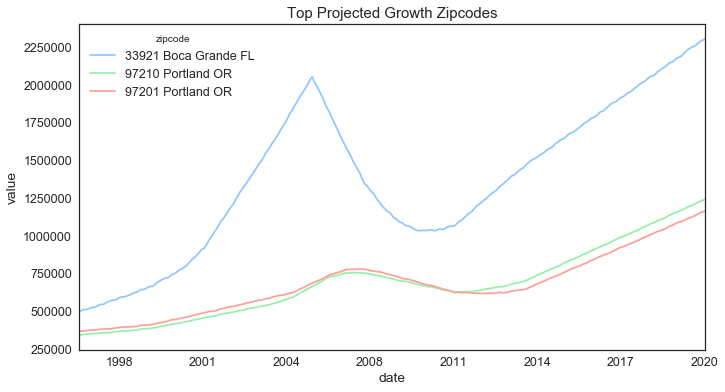

In [651]:
plt.figure(figsize=(10,6))

sns.set_style("white")

ax = sns.tsplot(plottingdf_melt, time='date', unit='zipcode', condition='zipcode', value='value')
#sns.set(font_scale=1.25)
ax.set_title('Top Projected Growth Zipcodes')
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))